## To Understand the Lerobot's PushT dataset Structure

In [2]:
!pip install pandas

In [3]:
!pip install pyarrow fastparquet

In [4]:
!pip install --upgrade huggingface-hub

In [5]:
import pandas as pd

### Episode 0

In [6]:
data = pd.read_parquet('/home/vinoth/.cache/huggingface/lerobot/lerobot/pusht/data/chunk-000/episode_000000.parquet')

In [10]:
data.head()

,observation.state,action,episode_index,frame_index,timestamp,next.reward,next.done,next.success,index,task_index
0,"[222.0, 97.0]","[233.0, 71.0]",0,0,0.0,0.190297,False,False,0,0
1,"[225.2524, 89.31253]","[229.0, 83.0]",0,1,0.1,0.190297,False,False,1,0
2,"[227.59233, 84.53438]","[229.0, 86.0]",0,2,0.2,0.190297,False,False,2,0
3,"[228.42017, 84.27986]","[230.0, 86.0]",0,3,0.3,0.190297,False,False,3,0
4,"[229.04222, 84.9571]","[239.0, 89.0]",0,4,0.4,0.190297,False,False,4,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   observation.state  161 non-null    object 
 1   action             161 non-null    object 
 2   episode_index      161 non-null    int64  
 3   frame_index        161 non-null    int64  
 4   timestamp          161 non-null    float32
 5   next.reward        161 non-null    float32
 6   next.done          161 non-null    bool   
 7   next.success       161 non-null    bool   
 8   index              161 non-null    int64  
 9   task_index         161 non-null    int64  
dtypes: bool(2), float32(2), int64(4), object(2)
memory usage: 9.2+ KB


In [17]:
data['timestamp']

0       0.0
1       0.1
2       0.2
3       0.3
4       0.4
       ... 
156    15.6
157    15.7
158    15.8
159    15.9
160    16.0
Name: timestamp, Length: 161, dtype: float32

In [18]:
data['observation.state']

0               [222.0, 97.0]
1        [225.2524, 89.31253]
2       [227.59233, 84.53438]
3       [228.42017, 84.27986]
4        [229.04222, 84.9571]
                ...          
156    [151.88667, 363.90482]
157    [153.53424, 363.95276]
158    [155.01678, 363.68158]
159    [156.57964, 362.48627]
160     [158.33017, 360.7482]
Name: observation.state, Length: 161, dtype: object

In [20]:
data['action']

0       [233.0, 71.0]
1       [229.0, 83.0]
2       [229.0, 86.0]
3       [230.0, 86.0]
4       [239.0, 89.0]
            ...      
156    [156.0, 364.0]
157    [157.0, 363.0]
158    [159.0, 360.0]
159    [161.0, 358.0]
160    [164.0, 355.0]
Name: action, Length: 161, dtype: object

In [21]:
data['next.done']

0      False
1      False
2      False
3      False
4      False
       ...  
156    False
157    False
158    False
159     True
160     True
Name: next.done, Length: 161, dtype: bool

In [33]:
for i in range(len(data['next.success'])):
    if data['next.success'][i] == True:
        print(f"Episode ends at index: {i} with success")
        break

In [4]:
import cv2
import numpy as np
import os
import time
import zarr

In [10]:

# --- CONFIGURATION ---
INPUT_VIDEO_PATH = '/home/vinoth/BTP/data/pusht_real/real_pusht_20230105/videos/0/3.mp4'
TARGET_RESOLUTION = (256, 256) # (Width, Height) used by Diffusion Policy
TARGET_FPS = 10 # Desired frame rate for the dataset (must match robot controller rate)

def extract_frames_from_video(video_path: str, target_res: tuple, target_fps: int) -> np.ndarray:
    """
    Loads a video file, extracts frames, resizes them, and ensures
    the output frame rate matches the target FPS by sampling frames.

    Returns:
        A NumPy array of shape (T, H, W, 3) with dtype uint8.
    """
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found at: {video_path}")

    # Initialize video capture object
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")

    # Get original video properties
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Original video FPS: {original_fps:.2f}")

    # Calculate the frame interval needed to hit the target FPS
    # We read one frame every 'frame_read_interval' steps
    if original_fps < target_fps:
        raise ValueError(f"Original FPS ({original_fps}) is lower than Target FPS ({target_fps}). Cannot upsample.")

    frame_read_interval = original_fps / target_fps
    
    frame_count = 0
    sampled_frames = []
    
    # Process the video frame by frame
    while cap.isOpened():
        # The capture position is based on the index count
        # We only read the frame if the index is close to an integer multiple of the interval
        
        # Read the frame
        ret, frame = cap.read()
        
        if not ret:
            break # End of video
        
        # Check if the current frame index is close to a target sample point
        if frame_count % frame_read_interval < 1:
            
            # 1. Convert BGR (OpenCV default) to RGB (ML standard)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # 2. Resize frame to target resolution (H, W)
            resized_frame = cv2.resize(
                rgb_frame, 
                target_res, # (Width, Height)
                interpolation=cv2.INTER_AREA # Good for shrinking images
            )
            
            # 3. Append to list
            sampled_frames.append(resized_frame)
            
        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()
    
    if not sampled_frames:
        print("Warning: No frames were sampled. Check frame rate settings.")
        return np.array([])

    # Stack list of (H, W, 3) images into final (T, H, W, 3) array
    images_array = np.stack(sampled_frames).astype(np.uint8)
    
    return images_array



In [17]:

try:
    start_time = time.time()
    print(f"Starting video processing: {INPUT_VIDEO_PATH}")
    
    images_array = extract_frames_from_video(
        INPUT_VIDEO_PATH, 
        TARGET_RESOLUTION, 
        TARGET_FPS
    )
    
    if images_array.size > 0:
        end_time = time.time()
        print("\n--- Processing Complete ---")
        print(f"Total Frames Extracted: {images_array.shape[0]}")
        print(f"Final Array Shape: {images_array.shape} (T, H, W, C)")
        print(f"Final Array Dtype: {images_array.dtype}")
        print(f"Time Elapsed: {end_time - start_time:.2f} seconds")

        # This 'images_array' is now ready to be stored in your Zarr dataset
        # at the path like '/rgb_static/episode_N/rgb_static'.
    ZARR_PATH = "episode_0.zarr"  # Adjust path/name as needed

    if images_array.size > 0:
        zarr.save(ZARR_PATH, images_array)
        print(f"Saved images to {ZARR_PATH}")
    else:
        print("No images to save.")
    
except (FileNotFoundError, IOError, ValueError) as e:
    print(f"Error: {e}")
    print("Please ensure the video path is correct and OpenCV is installed.")


Starting video processing: /home/vinoth/BTP/data/pusht_real/real_pusht_20230105/videos/0/3.mp4
Original video FPS: 30.00

--- Processing Complete ---
Total Frames Extracted: 171
Final Array Shape: (171, 256, 256, 3) (T, H, W, C)
Final Array Dtype: uint8
Time Elapsed: 0.80 seconds
Saved images to episode_0.zarr


Loaded array shape: (171, 256, 256, 3)
Data type: uint8


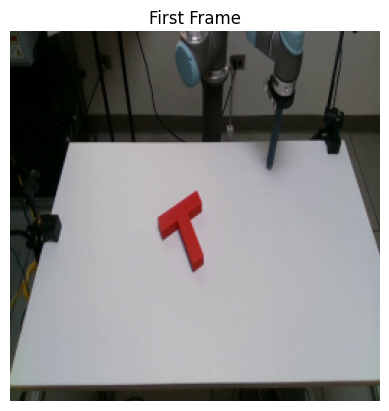

In [96]:
import zarr
import matplotlib.pyplot as plt

# Path to your saved Zarr dataset
ZARR_PATH = "episode_0.zarr"  # Adjust if needed

# Load the image array from Zarr
images_array = zarr.load(ZARR_PATH)

print(f"Loaded array shape: {images_array.shape}")
print(f"Data type: {images_array.dtype}")

# Display the first image as a sanity check
plt.imshow(images_array[170])
plt.title('First Frame')
plt.axis('off')
plt.show()
